**Variational Inference - Simple example**

Basic distributional setup


$P(D|u, \tau ) = (\frac{\tau}{2 \pi})^{N/2} exp (\frac{-\tau}{2} \sum_{n} (x_{n}-\mu)^{2})$

$P(\mu|\tau) = N(\mu|\mu_{0}, (\lambda_{0}\tau)^{-1})$

$P(\tau) = Gamma(\tau| a_{0}, b_{0})$

Assume trial distribution factorizes $q_{u}(u)q_{\tau}(\tau)$

$ln \  q_{\mu}(\mu) = E_{\tau}[ln(P(D,\mu|\tau)) + ln(P(\tau)] = E_{\tau}[ln(P(D,\mu|\tau))] + const.$

$=E_{\tau}[\frac{-\tau}{2} \sum_{n} (x_{n}-\mu)^{2} -\frac{\lambda_{0}\tau}{2}(\mu-\mu_{0})^{2}]$

$=\frac{-E_{\tau}[\tau]}{2}[\lambda_{0}(\mu-\mu_{0})^{2}+ \sum_{n} (x_{n}^{2} -2x_{n}\mu + \mu^{2})]$

Expanding and completing the square in $\mu$:

$=\frac{-E_{\tau}[\tau]}{2}[\lambda_{0}(\mu^{2}+\mu_{0}^{2} - 2\mu\mu_{0})+  (  N\mu^{2} -2N\bar{x}\mu + \sum_{n}x_{n}^{2})]$

Dropping terms not depending on $\mu$:

$=\frac{-E_{\tau}[\tau]}{2}[\lambda_{0}(\mu^{2}- 2\mu\mu_{0})+  (  N\mu^{2} -2N\bar{x}\mu )]$

$= \frac{-1}{2} [E_{\tau}[\tau](\lambda_{0}+N)\mu^{2} -2E_{\tau}[\tau](\lambda_{0}\mu_{0}+N\bar{x}) \mu]$

We can recognise this as a Gaussian with mean $\frac{\lambda_{0}\mu_{0}+N\bar{x}}{\lambda_{0}+N}$
and variance $E_{\tau}[\tau](\lambda_{0}+N)$.

This distibution is dependant on the expectation of $\tau$ under the corresponding trial distribution over $\tau$.

$ln \ q(\tau) = E_{\mu}[ln P(D|\mu,\tau)P(\mu|\tau)P(\tau)] =  E_{\mu}[ln \ P(D|\mu,\tau)P(\mu|\tau)]+ln \ P(\tau)$

Proceeding in the same way as above


$=E_{\mu}[\frac{-\tau}{2} \sum_{n} (x_{n}-\mu)^{2} -\frac{\lambda_{0}\tau}{2}(\mu-\mu_{0})^{2}] + (a_{0}-1)ln \ \tau -b_{0}\tau + \frac{1}{2}ln \ \tau + \frac{N}{2}ln \ \tau + const$


$=-\tau (b_{0}+ \frac{1}{2} E_{\mu}[\sum_{n} (x_{n}-\mu)^{2} +\lambda_{0}(\mu-\mu_{0})^{2}]) + (a_{0} + \frac{N+1}{2} - 1)ln \ \tau + const$

This is a Gamma distribution in $\tau $ with $b_{N} = (b_{0}+ \frac{1}{2} E_{\mu}[\sum_{n} (x_{n}-\mu)^{2} +\lambda_{0}(\mu-\mu_{0})^{2}])$ and $a_{N} = (a_{0} + \frac{N+1}{2})$

In [181]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [217]:
np.random.seed(42)
X=np.random.normal(0,1, size=(25,1))#+np.random.normal(0.2,1, size=(10,1))7
xs = np.arange(-1,1,.01)
ys = np.arange(0,2,.01)

In [259]:
#uninformative priors
lam0 = 0
mu0 = 0
a0 = 0
b0 = 0

#True Posterior parameters - as per https://en.wikipedia.org/wiki/Normal-gamma_distribution
mt = (X.sum()+lam0*mu0)/(len(X)+lam0) #mu
ln = len(X)+lam0 #lambda
bn = b0 + 0.5*((X**2).sum()+mu0*lam0 - ((X.sum()+lam0*mu0)**2)/(len(X)+lam0)) #beta
an = a0+0.5*len(X) #alpha

#For plotting contours
Xn, Yn = np.meshgrid(xs,ys)


In [260]:
def gaussian_moments(E_T, V_T):
    """Use the formula above to compute the gaussian moments in terms of the moments of tau,
    as derived at the start."""
    E_G = (lam0*mu0 + X.sum())/(lam0+len(X))
    V_G = ((lam0+len(X))*E_T)**-1
    return E_G, V_G

def gamma_moments(E_U, V_U):
    """Use the formula above to compute the gamma moments in terms of the moments of mu,
    as derived at the start."""
    d =X.T.dot(X) + len(X)*(V_U+(E_U**2))-2*X.sum()*E_U + lam0*(V_U+E_U**2)+lam0*(mu0**2)-2*lam0*mu0*E_U
    bn = b0+0.5*d
    an = a0 + 0.5*(len(X)+1)
    E_T = an/bn
    V_T = an/bn**2
    return E_T, V_T, an,bn

def gamma_gauss(x,t,u,l,a,b):
    """Implementation of the gamma-gauss distribution 
    https://en.wikipedia.org/wiki/Normal-gamma_distribution"""
    s = np.exp(-b*t)*np.exp(-l*t*0.5*(x-u)**2)*(t**(a-0.5))*(b**a)*(l**0.5)*(scipy.special.gamma(a)*((2*np.pi)**0.5))**-1
    return s

def plot_variational(E,V,a,b, axes):
    """Handler function to plot the current distribution"""
    gaus = st.norm(loc=E,scale=V**0.5)
    gamma = st.gamma(a,scale=b**-1)
    
    pxs=gaus.pdf(Xn)
    pys = gamma.pdf(Yn)
    z=pxs*pys
    axes.contour(Xn,Yn,z,colors='r')


In [261]:
zz = gamma_gauss(Xn,Yn,mt,ln,an,bn) #True posterior

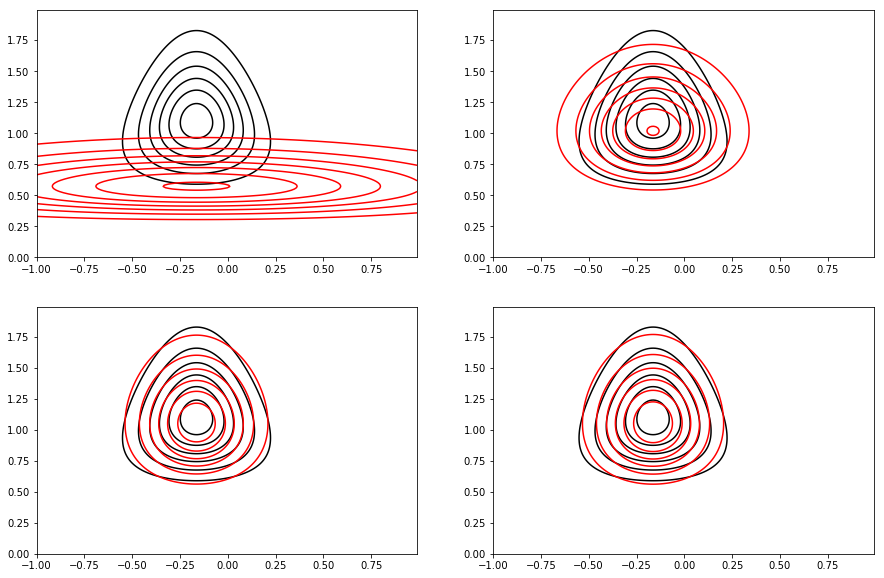

In [262]:
E_T = 0.05 #Initial guess for the moments of T
V_T = 0.01
plots = [0,1,2,99] #Which iterations to plot
fig = plt.figure(figsize=(15,10))
p=0
for i in range(100):
    E_U, V_U=gaussian_moments(E_T,V_T)
    E_T, V_T, an,bn = gamma_moments(E_U, V_U)
    
    if i in plots:
        
        ax = fig.add_subplot(221+p)
        ax.contour(Xn,Yn,zz,colors='k')
        plot_variational(E_U,V_U,an,bn,ax)
        p+=1